[blog](https://aws.amazon.com/blogs/machine-learning/bringing-your-own-custom-container-image-to-amazon-sagemaker-studio-notebooks/)

In [1]:
from icevision.all import *
from random import sample 
import albumentations as A
from fastai.callback.tracker import SaveModelCallback

In [2]:
import icevision
icevision.__version__

'0.5.2'

In [3]:
from pathlib import Path
import json

path = Path("../")

In [4]:
def sample_from_batch(path, i):
    ann = path / f"batch_{i}/JSON/kaggle_data_{i}.json"
    
    with open(ann) as f:
        data = json.load(f)
        
    samp = sample(data, 1000)
    return [{k: (path/f"batch_{i}/background_images/{v}"  if k=="filename" else v) for k, v in d.items()} for d in samp]

ann_path = Path(path / "annotations.pkl")
if ann_path.exists():
    annotations = pickle.load(open(ann_path, "rb"))
else:
    annotations = []
    for i in range(1, 11): annotations+=sample_from_batch(path, i)
    assert len(annotations) == 10000
    pickle.dump(annotations, open(ann_path, "wb"))

In [5]:
labels = []
for o in annotations: labels+=o["image_data"]["visible_latex_chars"]
labels= sorted(list(set(labels)))

class_map = ClassMap(labels)
len(class_map)

55

In [6]:
class_map.get_name("\lim_")

24

In [7]:
class LatexParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    
    def __init__(self, annotations_filepath, class_map):
        self.annotations_list = pickle.load(open(Path(annotations_filepath), "rb"))
        self.class_map = class_map
        
    def __iter__(self):
        yield from self.annotations_list
        
    def imageid(self, o):
        return Path(o["filename"]).stem
    
    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))
    
    def filepath(self, o):
        return o["filename"]
    
    def bboxes(self, o):
        boxes = []
        for xmin, ymin, xmax, ymax in zip(o["image_data"]["xmins_raw"], o["image_data"]["ymins_raw"], o["image_data"]["xmaxs_raw"], o["image_data"]["ymaxs_raw"]):
            boxes.append(BBox.from_xyxy(xmin, ymin, xmax, ymax))
        return boxes
    
    def labels(self, o):
        return [self.class_map.get_name(label) for label in o["image_data"]["visible_latex_chars"]]

In [8]:
parser = LatexParser(path / "annotations.pkl", class_map)

In [9]:
train_rs, valid_rs = parser.parse(cache_filepath=path / "cached_records.pkl")

INFO     - Loading cached records from ../cached_records.pkl | icevision.parsers.parser:parse:115


In [10]:
len(train_rs), len(valid_rs)

(8000, 2000)

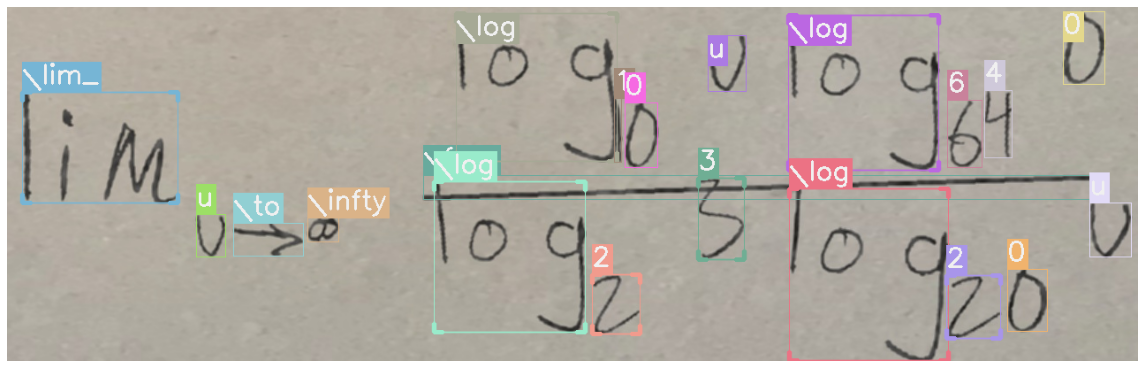

In [11]:
show_records(train_rs[:1], ncols=1, class_map=class_map, figsize=(16,7))

In [12]:
from PIL import Image
im = Image.open(train_rs[0]["filepath"])
im.size

(1280, 401)

In [13]:
presize = 1280

size = 896
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize, 
                                              shift_scale_rotate=A.ShiftScaleRotate(rotate_limit=10), 
                                              crop_fn=None,
                                              horizontal_flip=None,), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

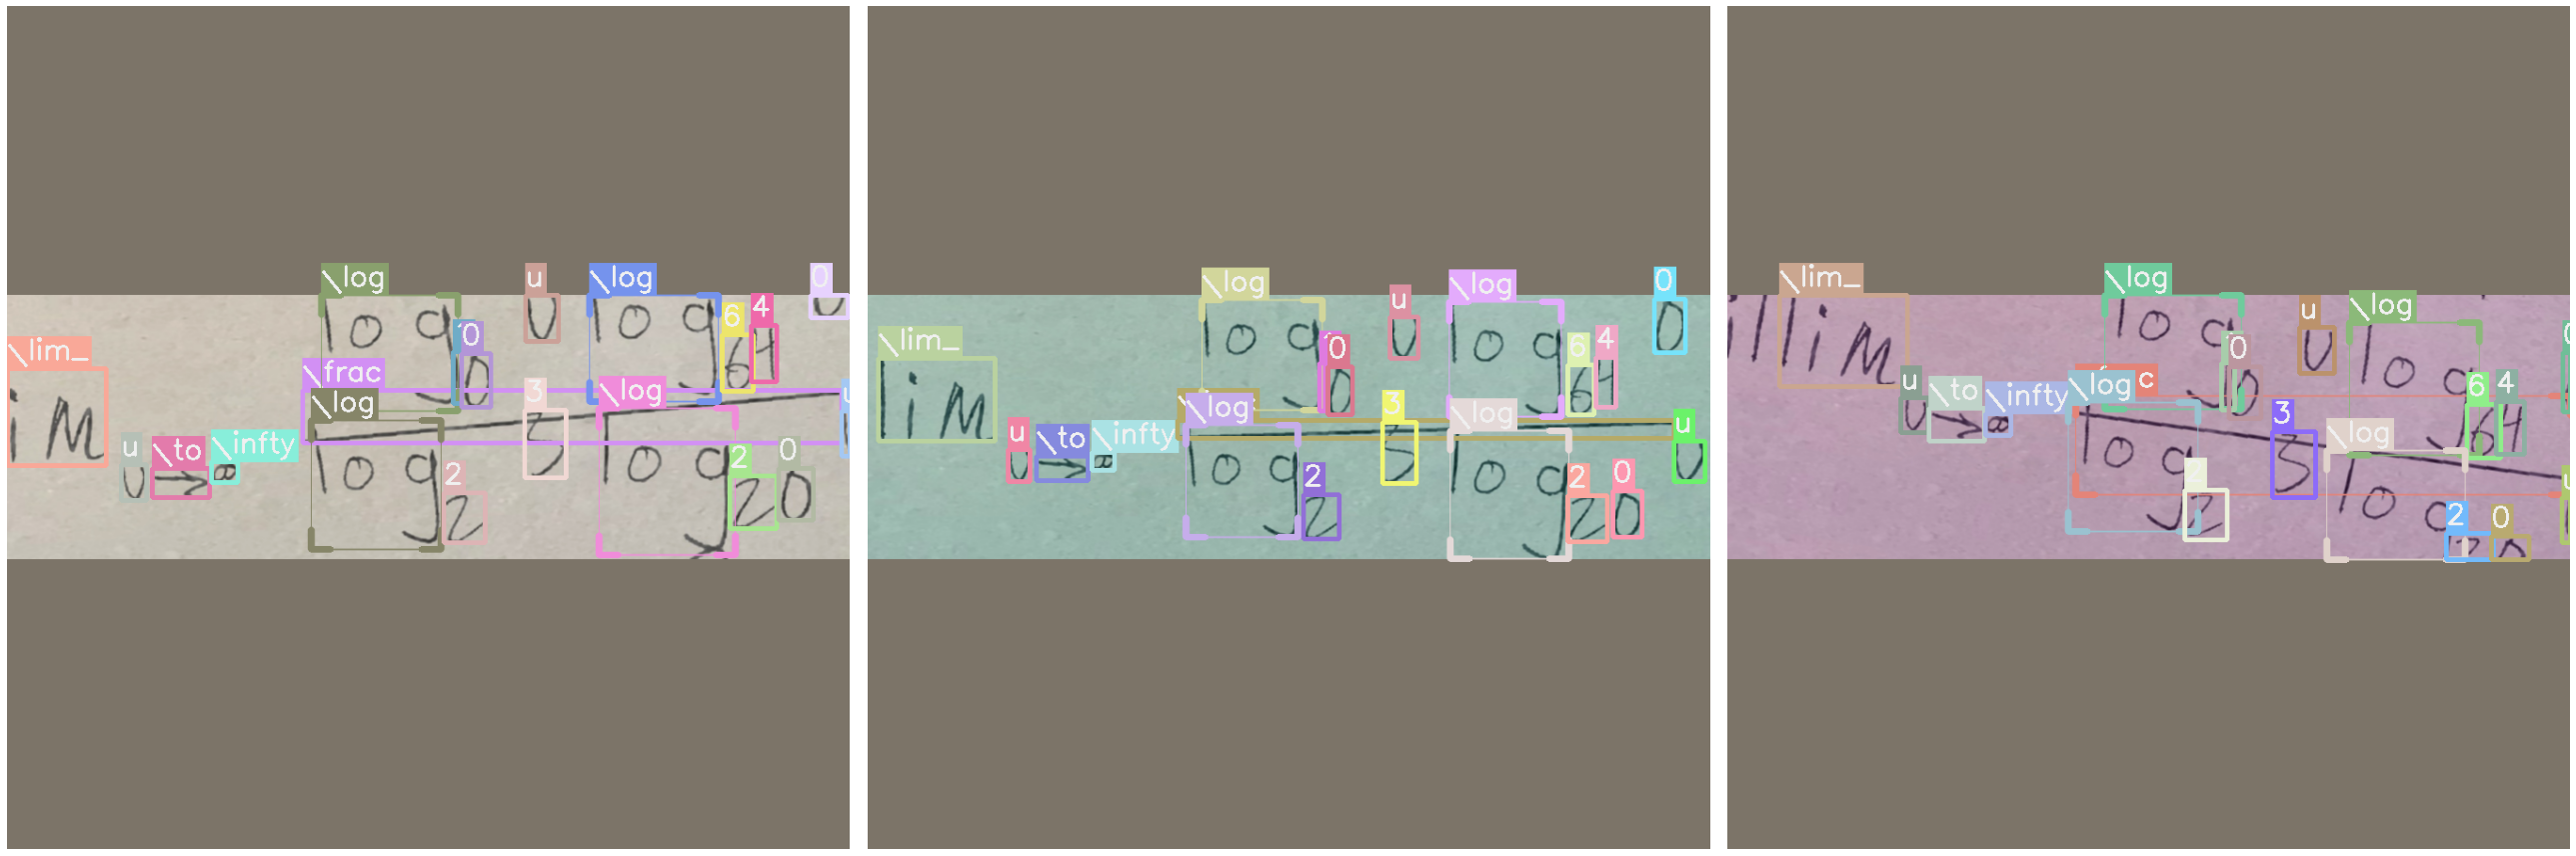

In [14]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map, denormalize_fn=denormalize_imagenet)

In [15]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=8, num_workers=2, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=8, num_workers=2, shuffle=False)

In [16]:
model = faster_rcnn.model(num_classes=len(class_map))

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=[SaveModelCallback()])

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=3.630780702224001e-05)

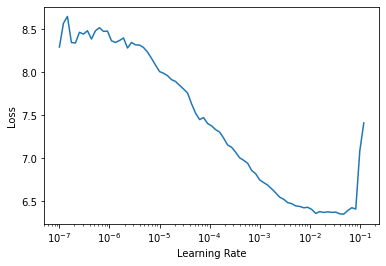

In [17]:
learn.freeze()
learn.lr_find()

In [17]:
learn.fine_tune(10, lr=4.7e-3)

epoch,train_loss,valid_loss,COCOMetric,time
0,4.609854,5.075520,0.300196,14:47


Better model found at epoch 0 with valid_loss value: 5.075519561767578.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,COCOMetric,time
0,0.694934,0.688889,0.685824,20:54
1,0.651680,0.652869,0.689735,20:43
2,0.580893,0.596290,0.724103,20:44
3,0.526209,0.505009,0.764492,20:47
4,0.468428,0.461174,0.789335,20:30
5,0.424937,0.405310,0.812144,21:05
6,0.373820,0.362362,0.832637,20:48
7,0.328429,0.325931,0.851741,20:43
8,0.304321,0.307856,0.862750,20:41
9,0.296657,0.305252,0.861076,20:40


Better model found at epoch 0 with valid_loss value: 0.6888885498046875.
Better model found at epoch 1 with valid_loss value: 0.6528692245483398.
Better model found at epoch 2 with valid_loss value: 0.5962897539138794.
Better model found at epoch 3 with valid_loss value: 0.5050086975097656.
Better model found at epoch 4 with valid_loss value: 0.4611736238002777.
Better model found at epoch 5 with valid_loss value: 0.40531033277511597.
Better model found at epoch 6 with valid_loss value: 0.362361878156662.
Better model found at epoch 7 with valid_loss value: 0.3259311616420746.
Better model found at epoch 8 with valid_loss value: 0.30785566568374634.
Better model found at epoch 9 with valid_loss value: 0.305252343416214.


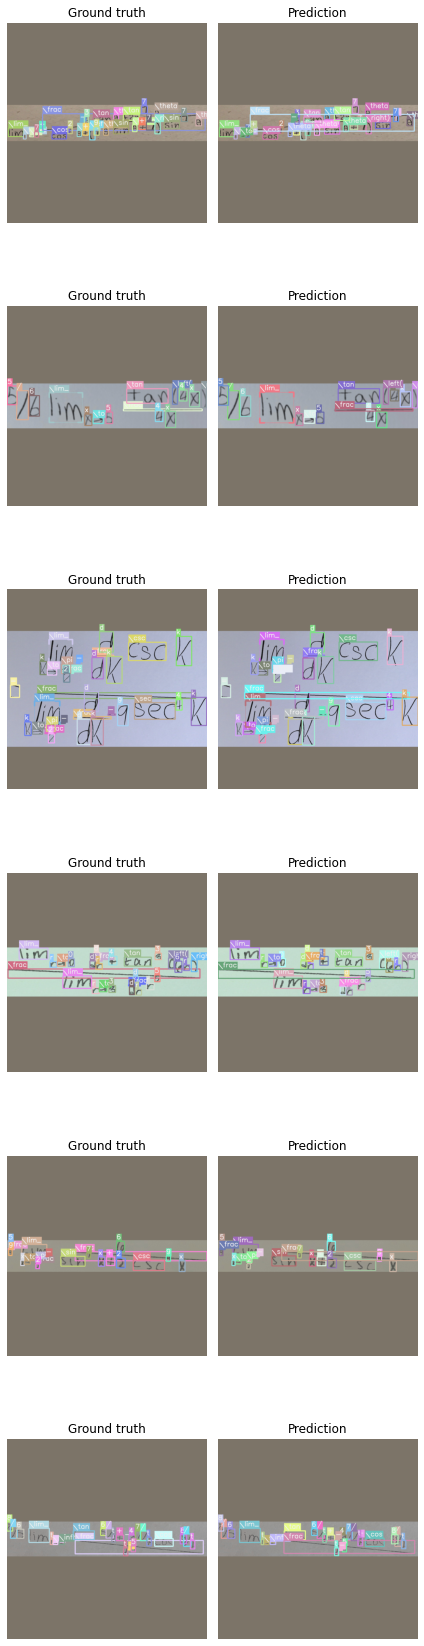

In [18]:
faster_rcnn.show_results(model, valid_ds, class_map)

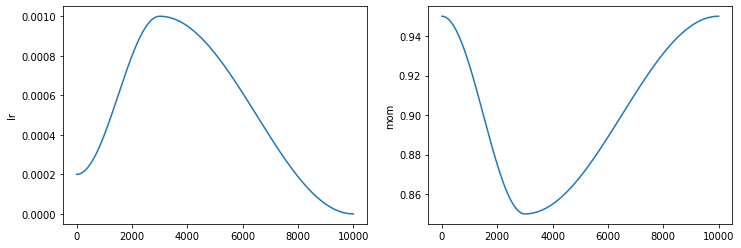

In [19]:
learn.recorder.plot_sched()

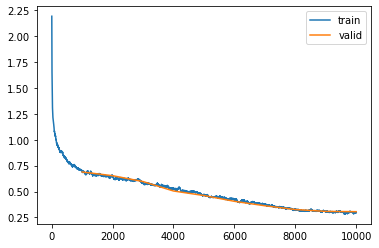

In [20]:
learn.recorder.plot_loss()

In [21]:
learn.save("learner")

Path('models/learner.pth')

In [22]:
torch.save(model.state_dict(), './models/model_final.pth')

In [24]:
im = Image.open(train_rs[0]["filepath"])
print(im.size)
image = [np.asarray(im)]
image[0].shape

(1280, 401)


(401, 1280, 3)

In [25]:
infer_ds = Dataset.from_images(images=image, tfm=valid_tfms)
infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)

In [30]:
x, sample = first(infer_dl)
x[0].shape

torch.Size([1, 3, 896, 896])

In [31]:
infer_model = faster_rcnn.model(num_classes=len(class_map))
infer_model.load_state_dict(torch.load('./models/model_final.pth'))

<All keys matched successfully>

In [32]:
samples, preds = faster_rcnn.predict_dl(infer_model, infer_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

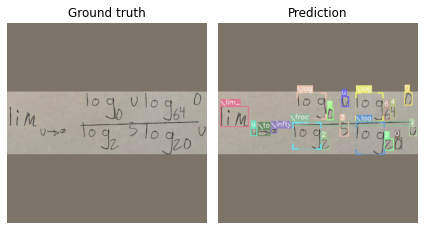

In [34]:
show_preds(
    samples=samples,
    preds=preds,
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    show=True,
)